# Analysing COD/CIS Images

## Values in the "unknown" part(s) of the header

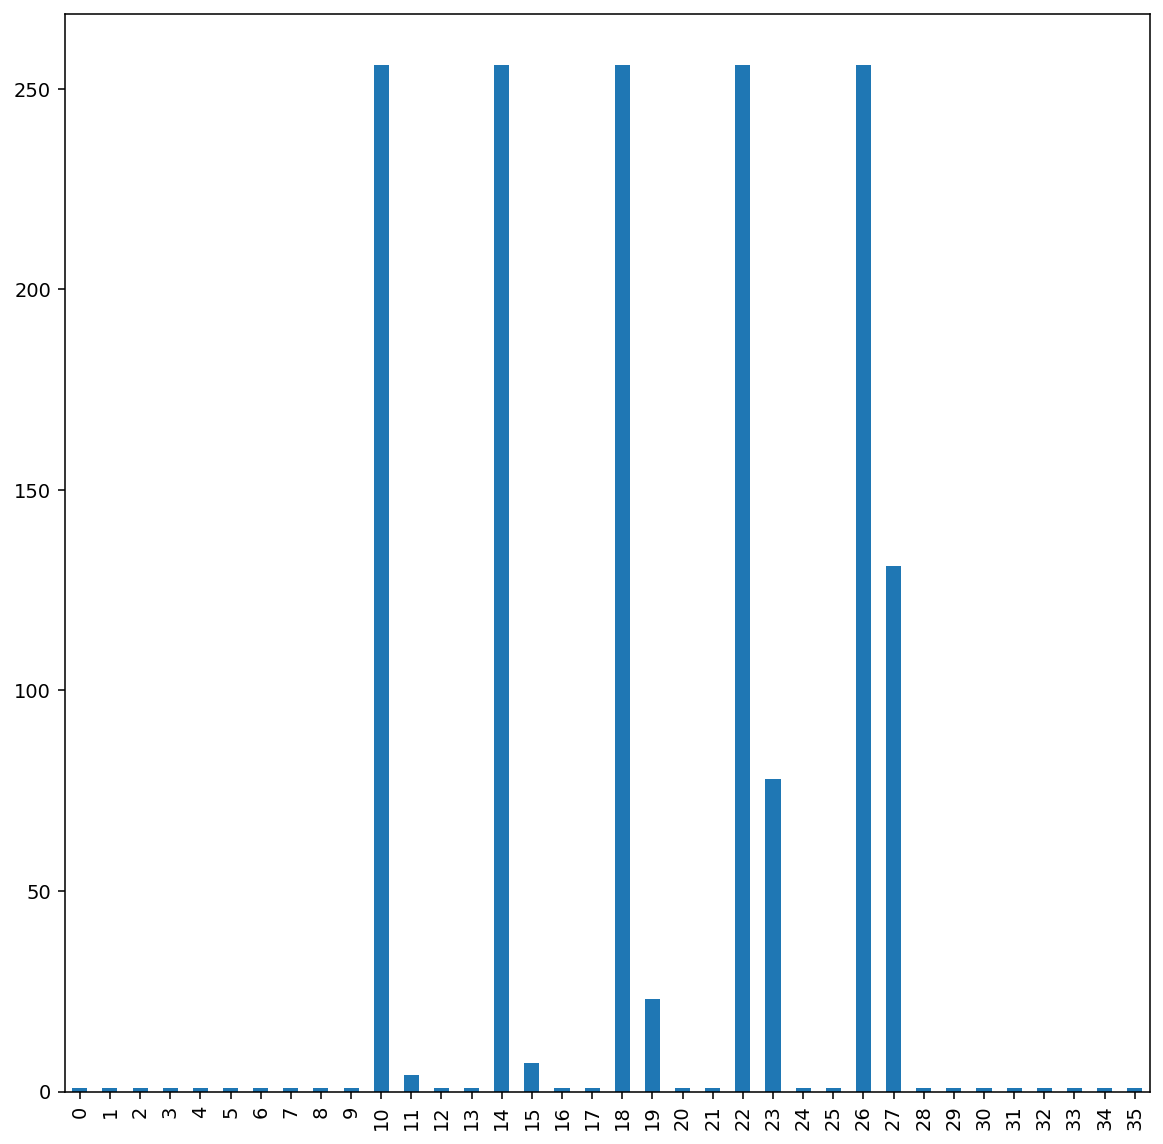

In [57]:
from dsat import Dsat
import pandas as pd
import matplotlib.pyplot as plt

d = Dsat.from_file("../dsatnord.mp")

data = []
for t in d.tiles_zoom3.tiles:
    data.append([int(h) for h in t.header.unknown5])

df = pd.DataFrame(data)
df.nunique().plot.bar()
plt.show()

In [ ]:
from dsat import Dsat
import pandas as pd
d = Dsat.from_file("../dsatnord.mp")

df = pd.DataFrame([[int(h) for h in t.header.unknown5] for t in d.tiles_zoom1.tiles])

In [111]:
df

0   1   2   3   4   5   6   7   8   9   ...   30  31  32  33  34  35  36  \
0    24   1   0   0   1   1   1   1   1   5  ...   33   0   0   0   0   0   2   
1    24   1   0   0   1   1   1   1   1   5  ...   33   0   0   0   0   0   2   
2    24   1   0   0   1   1   1   1   1   5  ...   33   0   0   0   0   0   2   
3    24   1   0   0   1   1   1   1   1   5  ...   33   0   0   0   0   0   2   
4    24   1   0   0   1   1   1   1   1   5  ...  126   2   0   0   0   0   2   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ..  ..  ..  ..   
164  24   1   0   0   1   1   1   1   1   5  ...  105  43   0   0   0   0   1   
165  24   1   0   0   1   1   1   1   1   5  ...  134  78   0   0   0   0   1   
166  24   1   0   0   1   1   1   1   1   5  ...   39   6   0   0   0   0   2   
167  24   1   0   0   1   1   1   1   1   5  ...   59   3   0   0   0   0   2   
168  24   1   0   0   1   1   1   1   1   5  ...   33   0   0   0   0   0   2   

     37  38  39  
0     0   2   0  
1     0   2   0  
2     0   2   0  
3     0   2   0  
4     0   2   0  
..   ..  ..  ..  
164   0   2   0  
165   0   2   0  
166   0   2   0  
167   0   2   0  
168   0   2   0  

[169 rows x 40 columns]

## Stats about "cod" parts

### Number of parts per tile

In [22]:
import pandas as pd
from cis import Cis

def le16(b):
    return int.from_bytes(b, byteorder="little", signed=False)

def get_planes(b):
    """Statistics about "cod" parts in byte array b."""
    planes = []
    lastpos = 0
    for i in range(0, len(b) - 2):
        if chr(b[i]) == 'c' and chr(b[i+1]) == 'o' and chr(b[i+2]) == 'd':
            planes.append(b[lastpos:i])
            lastpos = i + 3
    return planes

img = "../img/wolf.cod"
img = "../img/tile_644684211.cod"

c = Cis.from_file(img)

planes = get_planes(c.data.planes)

[(le16(b[0:2]), le16(b[2:4]), le16(b[4:6]), len(b)) for b in planes]

[(1338, 61620, 30, 651),
 (1001, 63941, 16, 507),
 (1177, 63825, 16, 500),
 (1012, 64637, 12, 447),
 (708, 64679, 12, 1578),
 (806, 64524, 12, 1554),
 (536, 64979, 10, 1498),
 (513, 64926, 10, 4112),
 (522, 64769, 10, 3879),
 (442, 65223, 8, 2502),
 (301, 65075, 8, 3249),
 (245, 65260, 8, 3057),
 (200, 65356, 4, 561)]

In [42]:
from dsat import Dsat
import pandas as pd

d = Dsat.from_file("../dsatnord.mp")

def count_cod(b):
    """Statistics about "cod" parts in byte array b."""
    pos = []
    for i in range(0, len(b) - 2):
        if chr(b[i]) == 'c' and chr(b[i+1]) == 'o' and chr(b[i+2]) == 'd':
            pos.append(i)
    return len(pos)

print(0, pd.DataFrame([count_cod(t.data.unknown) for t in d.tiles_zoom0.tiles]).value_counts(), sep='\n')
print(1, pd.DataFrame([count_cod(t.data.unknown) for t in d.tiles_zoom1.tiles]).value_counts(), sep='\n')
print(2, pd.DataFrame([count_cod(t.data.unknown) for t in d.tiles_zoom2.tiles]).value_counts(), sep='\n')
print(3, pd.DataFrame([count_cod(t.data.unknown) for t in d.tiles_zoom3.tiles]).value_counts(), sep='\n')

0
39    17
42     2
48     1
dtype: int64
1
36    162
39      7
dtype: int64
2
36    2238
37       1
39       1
dtype: int64
3
13    24667
14       33
dtype: int64


### Looking at some header parts

There are still some parts in the header whose purpose is not clear, yet. Thus, we here look at the bytes in the part named `unknown5`:

In [5]:
from dsat import Dsat
from cis import Cis
import pandas as pd
import os

def count_cod(b):
    """Statistics about "cod" parts in byte array b."""
    pos = []
    for i in range(0, len(b) - 2):
        if chr(b[i]) == 'c' and chr(b[i+1]) == 'o' and chr(b[i+2]) == 'd':
            pos.append(i)
    return len(pos)


def header_stats(img):
    return [
        img.header.width, 
        img.header.height, 
        count_cod(img.data.planes),
        int(img.header.unknown2[0]),
        int(img.header.unknown2[1])
    ] + [int(i) for i in img.header.unknown5]


def stats(name, tiles):
    return [[name] + header_stats(img) for img in tiles]


def get_cods(path):
    if os.path.isdir(path):
        for fname in os.listdir(path):
            name, ext = os.path.splitext(fname)
            if ext == ".cod":
                yield [name] + header_stats(Cis.from_file(os.path.join(path, fname)))

                
d = Dsat.from_file("../dsatnord.mp")

df = pd.DataFrame(
    [cod for cod in get_cods("../cod/")] + 
    stats("zoom0", d.tiles_zoom0.tiles) + 
    stats("zoom1", d.tiles_zoom1.tiles) + 
    stats("zoom2", d.tiles_zoom2.tiles) + 
    stats("zoom3", d.tiles_zoom3.tiles),
    columns = [
        "name", "width", "height", "bands", "u2a", "u2b"
    ] + ["h" + str(i) for i in range(43 - 3)]
)

df

name  width  height  bands  u2a  u2b  h0  h1  h2  h3  ...  h30  h31  \
0          p02    480     320     30   26    4  24   1   0   0  ...  127    4   
1         wolf    768     512     33   10    0  24   1   0   0  ...   49    0   
2      patmos1    572     392     27   26    4  24   1   0   0  ...  167    9   
3          dci    544     416     33   26    4  24   1   0   0  ...  148    8   
4         ugly    640     480     36   26    4  24   1   0   0  ...  199    0   
...        ...    ...     ...    ...  ...  ...  ..  ..  ..  ..  ...  ...  ...   
27142    zoom3   1000    1000     13   26    4   8   0   0   0  ...    0    0   
27143    zoom3   1000    1000     13   26    4   8   0   0   0  ...    0    0   
27144    zoom3   1000    1000     13   26    4   8   0   0   0  ...    0    0   
27145    zoom3   1000    1000     13   26    4   8   0   0   0  ...    0    0   
27146    zoom3   1000    1000     13   26    4   8   0   0   0  ...    0    0   

       h32  h33  h34  h35  h36  h37  h38  h39  
0        0    0    0    0  3.0  0.0  3.0  0.0  
1        0    0    0    0  1.0  1.0  2.0  1.0  
2        0    0    0    0  3.0  0.0  4.0  0.0  
3        0    0    0    0  2.0  0.0  3.0  0.0  
4        0    0    0    0  2.0  0.0  2.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  ...  
27142    0    0    1    0  NaN  NaN  NaN  NaN  
27143    0    0    1    0  NaN  NaN  NaN  NaN  
27144    0    0    1    0  NaN  NaN  NaN  NaN  
27145    0    0    1    0  NaN  NaN  NaN  NaN  
27146    0    0    1    0  NaN  NaN  NaN  NaN  

[27147 rows x 46 columns]

Only few bytes of `unknown5` change from image to image: mainly `h10` to `h33` which might represent six 32 bit numbers, given their value distribution in the first plot of this notebook. Thus, we focus on the parts which are the same for most images and try to understand their meaning: 

In [6]:
dfa = df.drop(columns = [
    "h10", "h11", "h12", "h13",
    "h14", "h15", "h16", "h17",
    "h18", "h19", "h20", "h21",
    "h22", "h23", "h24", "h25",
    "h26", "h27", "h28", "h29",
    "h30", "h31", "h32", "h33"
]).drop_duplicates().sort_values("bands")
dfa

name  width  height  bands  u2a  u2b  h0  h1  h2  h3  ...  h6  h7  \
2447       zoom3   1000    1000     13   26    4   8   0   0   0  ...   1   1   
4426       zoom3   1000    1000     14   26    4   8   0   0   0  ...   1   1   
12      lenagray    512     512     16   26    4   8   0   0   0  ...   1   1   
13    exodus2000   2002    1406     16   26    4   8   0   0   0  ...   1   1   
2        patmos1    572     392     27   26    4  24   1   0   0  ...   1   1   
15           p01    480     320     30   26    4  24   1   0   0  ...   1   1   
17           p03    480     320     30   26    4  24   1   0   0  ...   1   1   
16           cow    512     512     30   26    4  24   1   0   0  ...   1   1   
14           fox    640     480     30   10    0  24   1   0   0  ...   1   1   
11           p04    480     320     30   26    4  24   1   0   0  ...   1   1   
0            p02    480     320     30   26    4  24   1   0   0  ...   1   1   
9          eagle    544     416     30   26    4  24   1   0   0  ...   1   1   
6          laura    448     640     30   26    4  24   1   0   0  ...   1   1   
5          sally    512     768     30   26    4  24   1   0   0  ...   1   1   
10           p10    480     320     30   26    4  24   1   0   0  ...   1   1   
8            p07    480     320     33   26    4  24   1   0   0  ...   1   1   
1           wolf    768     512     33   10    0  24   1   0   0  ...   1   1   
7            p09    480     320     33   26    4  24   1   0   0  ...   1   1   
3            dci    544     416     33   26    4  24   1   0   0  ...   1   1   
207        zoom2    500     500     36   26    4  24   1   0   0  ...   1   1   
38         zoom1    500     500     36   26    4  24   1   0   0  ...   1   1   
4           ugly    640     480     36   26    4  24   1   0   0  ...   1   1   
1019       zoom2    500     500     37   26    4  24   1   0   0  ...   1   1   
147        zoom1    500     500     39   26    4  24   1   0   0  ...   1   1   
520        zoom2    500     500     39   26    4  24   1   0   0  ...   1   1   
19         zoom0    250     250     39   26    4  24   1   0   0  ...   1   1   
22         zoom0    250     250     42   26    4  24   1   0   0  ...   1   1   
18         zoom0    250     250     48   26    4  24   1   0   0  ...   1   1   

      h8  h9  h34  h35  h36  h37  h38  h39  
2447   1   5    1    0  NaN  NaN  NaN  NaN  
4426   1   5    1    0  NaN  NaN  NaN  NaN  
12     1   5    0    0  NaN  NaN  NaN  NaN  
13     1   5    0    0  NaN  NaN  NaN  NaN  
2      1   5    0    0  3.0  0.0  4.0  0.0  
15     1   5    0    0  3.0  0.0  3.0  0.0  
17     1   5    0    0  3.0  0.0  3.0  0.0  
16     1   5    0    0  3.0  0.0  3.0  0.0  
14     1   5    0    0  2.0  1.0  2.0  1.0  
11     1   5    0    0  3.0  0.0  3.0  0.0  
0      1   5    0    0  3.0  0.0  3.0  0.0  
9      1   5    0    0  3.0  0.0  3.0  0.0  
6      1   5    0    0  3.0  0.0  3.0  0.0  
5      1   5    0    0  3.0  0.0  3.0  0.0  
10     1   5    0    0  3.0  0.0  3.0  0.0  
8      1   5    0    0  2.0  0.0  3.0  0.0  
1      1   5    0    0  1.0  1.0  2.0  1.0  
7      1   5    0    0  2.0  0.0  3.0  0.0  
3      1   5    0    0  2.0  0.0  3.0  0.0  
207    1   5    0    0  2.0  0.0  2.0  0.0  
38     1   5    0    0  2.0  0.0  2.0  0.0  
4      1   5    0    0  2.0  0.0  2.0  0.0  
1019   1   5    0    0  2.0  0.0  2.0  0.0  
147    1   5    0    0  1.0  0.0  2.0  0.0  
520    1   5    0    0  1.0  0.0  2.0  0.0  
19     1   5    0    0  1.0  0.0  2.0  0.0  
22     1   5    0    0  1.0  0.0  1.0  0.0  
18     1   5    0    0  0.0  0.0  0.0  0.0  

[28 rows x 22 columns]

Given that the zoom3 images are greyscale and all others colour, we could guess the following purposes:

| byte | purpose |
|------|:--------|
|  `h0`  | number of bits for each pixel (8 for greyscale, 24 for colour)? |
|  `h1`  | greyscale vs. colour? |
|  `h9`  | default depth of wavelet decomposition? |
| `h34` to `h39` | "relative depths" for the individual colour components (two for each?) |

Given the depth *d*, the number of bands for one component (e.g., colour) is computed as *3d + 1*. So for the greyscale images, a depth of *5 - 1 = 4* would result in *3 * 4 + 1 = 13* bands which fits nicely to almost all of the greyscale images (24667 out of 24700).

Let's define a function that computes the number of bands for colour images from a default depth and relative depths for each of the three components of the [Y'UV colour model](https://en.wikipedia.org/wiki/Y%E2%80%B2UV): 

In [7]:
from numpy import NaN

def calc_band(default_depth, delta1, delta2):
    """Compute 3*(default_depth - delta1 - delta 2) + 1."""
    # Greyscale images have no value (NaN) for delta1 and delta2 for the colour compontents.
    # To get a meaningful result, we replace both NaNs such that the result is 0:
    # 3 * (default_depth - default_depth - 1/3) + 1 = 0
    return (3 * (default_depth - delta1.fillna(default_depth) - delta2.fillna(1/3)) + 1).astype(int)

def calc_bands(default_depth, y, yy, b, bb, r, rr):
    """Take a default depth and subtract the individual 'relative depths' for 
    each colour component. Why two values per colour component?"""
    # Y' = luma
    # Cb = blue difference
    # Cr = red difference
    return calc_band(default_depth, y, yy) + calc_band(default_depth, b, bb) + calc_band(default_depth, r, rr)

Let's take the values h34 to h39 as pairs of relative depths for y, b, and r, respectively:

In [8]:
dfa["bands'"] = calc_bands(dfa.h9, dfa.h34, dfa.h35, dfa.h36, dfa.h37, dfa.h38, dfa.h39)
dfa["b == b'?"] = dfa["bands"] == dfa["bands'"]
dfa

name  width  height  bands  u2a  u2b  h0  h1  h2  h3  ...  h8  h9  \
2447       zoom3   1000    1000     13   26    4   8   0   0   0  ...   1   5   
4426       zoom3   1000    1000     14   26    4   8   0   0   0  ...   1   5   
12      lenagray    512     512     16   26    4   8   0   0   0  ...   1   5   
13    exodus2000   2002    1406     16   26    4   8   0   0   0  ...   1   5   
2        patmos1    572     392     27   26    4  24   1   0   0  ...   1   5   
15           p01    480     320     30   26    4  24   1   0   0  ...   1   5   
17           p03    480     320     30   26    4  24   1   0   0  ...   1   5   
16           cow    512     512     30   26    4  24   1   0   0  ...   1   5   
14           fox    640     480     30   10    0  24   1   0   0  ...   1   5   
11           p04    480     320     30   26    4  24   1   0   0  ...   1   5   
0            p02    480     320     30   26    4  24   1   0   0  ...   1   5   
9          eagle    544     416     30   26    4  24   1   0   0  ...   1   5   
6          laura    448     640     30   26    4  24   1   0   0  ...   1   5   
5          sally    512     768     30   26    4  24   1   0   0  ...   1   5   
10           p10    480     320     30   26    4  24   1   0   0  ...   1   5   
8            p07    480     320     33   26    4  24   1   0   0  ...   1   5   
1           wolf    768     512     33   10    0  24   1   0   0  ...   1   5   
7            p09    480     320     33   26    4  24   1   0   0  ...   1   5   
3            dci    544     416     33   26    4  24   1   0   0  ...   1   5   
207        zoom2    500     500     36   26    4  24   1   0   0  ...   1   5   
38         zoom1    500     500     36   26    4  24   1   0   0  ...   1   5   
4           ugly    640     480     36   26    4  24   1   0   0  ...   1   5   
1019       zoom2    500     500     37   26    4  24   1   0   0  ...   1   5   
147        zoom1    500     500     39   26    4  24   1   0   0  ...   1   5   
520        zoom2    500     500     39   26    4  24   1   0   0  ...   1   5   
19         zoom0    250     250     39   26    4  24   1   0   0  ...   1   5   
22         zoom0    250     250     42   26    4  24   1   0   0  ...   1   5   
18         zoom0    250     250     48   26    4  24   1   0   0  ...   1   5   

      h34  h35  h36  h37  h38  h39  bands'  b == b'?  
2447    1    0  NaN  NaN  NaN  NaN      13      True  
4426    1    0  NaN  NaN  NaN  NaN      13     False  
12      0    0  NaN  NaN  NaN  NaN      16      True  
13      0    0  NaN  NaN  NaN  NaN      16      True  
2       0    0  3.0  0.0  4.0  0.0      27      True  
15      0    0  3.0  0.0  3.0  0.0      30      True  
17      0    0  3.0  0.0  3.0  0.0      30      True  
16      0    0  3.0  0.0  3.0  0.0      30      True  
14      0    0  2.0  1.0  2.0  1.0      30      True  
11      0    0  3.0  0.0  3.0  0.0      30      True  
0       0    0  3.0  0.0  3.0  0.0      30      True  
9       0    0  3.0  0.0  3.0  0.0      30      True  
6       0    0  3.0  0.0  3.0  0.0      30      True  
5       0    0  3.0  0.0  3.0  0.0      30      True  
10      0    0  3.0  0.0  3.0  0.0      30      True  
8       0    0  2.0  0.0  3.0  0.0      33      True  
1       0    0  1.0  1.0  2.0  1.0      33      True  
7       0    0  2.0  0.0  3.0  0.0      33      True  
3       0    0  2.0  0.0  3.0  0.0      33      True  
207     0    0  2.0  0.0  2.0  0.0      36      True  
38      0    0  2.0  0.0  2.0  0.0      36      True  
4       0    0  2.0  0.0  2.0  0.0      36      True  
1019    0    0  2.0  0.0  2.0  0.0      36     False  
147     0    0  1.0  0.0  2.0  0.0      39      True  
520     0    0  1.0  0.0  2.0  0.0      39      True  
19      0    0  1.0  0.0  2.0  0.0      39      True  
22      0    0  1.0  0.0  1.0  0.0      42      True  
18      0    0  0.0  0.0  0.0  0.0      48      True  

[28 rows x 24 columns]

The computed number of bands fits nicely for almost all colour tiles, except only one (!) zoom2 tile with 37 bands. The "fox" and "wolf" example images are the only ones that have non-zero values for `h37` and `h39`, thus requiring these two "extra" relative depths. Would be interesting to know what they mean.

### Number of distinct distances between parts

In [51]:
from dsat import Dsat
import pandas as pd

d = Dsat.from_file("../dsatnord.mp")

def count_cod(b):
    """Statistics about "cod" parts in byte array b."""
    dists = set()
    lastpos = 0
    for i in range(0, len(b) - 2):
        if chr(b[i]) == 'c' and chr(b[i+1]) == 'o' and chr(b[i+2]) == 'd':
            dists.add(i - lastpos)
    return len(dists)

print(0, pd.DataFrame([count_cod(t.data.unknown) for t in d.tiles_zoom0.tiles]).value_counts(), sep='\n')
print(1, pd.DataFrame([count_cod(t.data.unknown) for t in d.tiles_zoom1.tiles]).value_counts(), sep='\n')
print(2, pd.DataFrame([count_cod(t.data.unknown) for t in d.tiles_zoom2.tiles]).value_counts(), sep='\n')
print(3, pd.DataFrame([count_cod(t.data.unknown) for t in d.tiles_zoom3.tiles]).value_counts(), sep='\n')

0
39    17
42     2
48     1
dtype: int64
1
36    162
39      7
dtype: int64
2
36    2238
37       1
39       1
dtype: int64
3
13    24667
14       33
dtype: int64


### Size Distribution of Sub-Bands

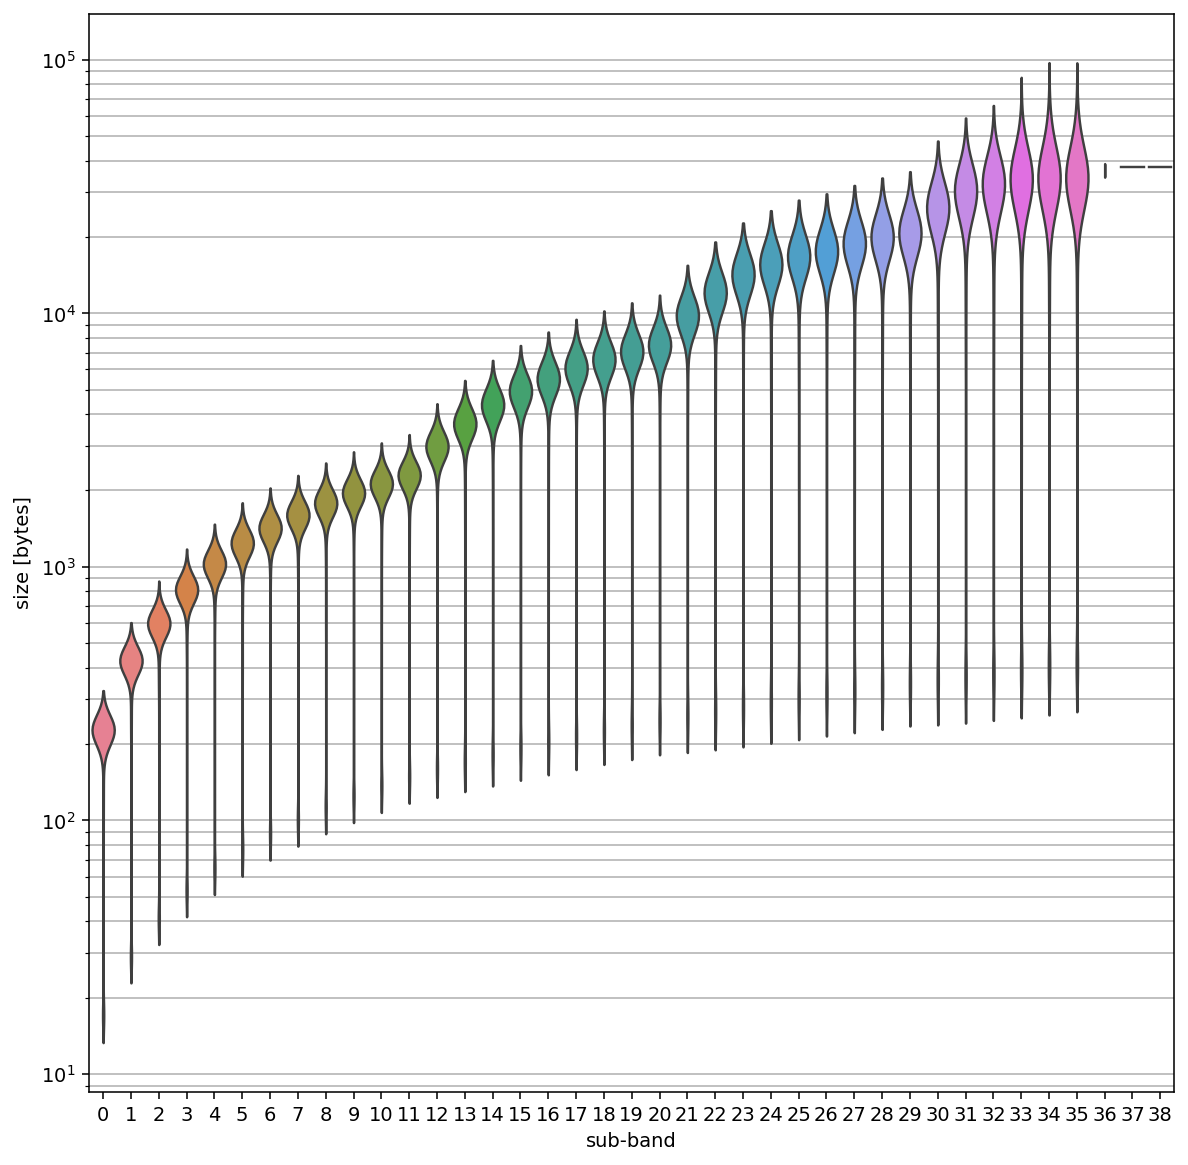

In [55]:
from dsat import Dsat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.dpi'] = 140

def cod_sizes(b):
    """Sizes of "cod"-delimited parts in byte array b."""
    sizes = []
    lastpos = 0
    for i in range(0, len(b) - 2):
        if chr(b[i]) == 'c' and chr(b[i+1]) == 'o' and chr(b[i+2]) == 'd':
            sizes.append(i - lastpos)
    return sizes

df = pd.DataFrame([cod_sizes(t.data.planes) for t in Dsat.from_file("../dsatnord.mp").tiles_zoom3.tiles])

ax = sns.violinplot(df, inner=None, split=False, log_scale=True, zorder=3, density_norm="count", common_norm=True)
plt.ylabel("size [bytes]")
plt.xlabel("sub-band")
plt.grid(axis="y", which="both", zorder=0)
for i in df.columns:
    ax.text(i + 0.1, df[[i]].min().iloc[0], "{:2.0f}".format(df[[i]].mean().iloc[0]))

plt.show()